# Unit Commitment (UC)
This notebook is inspired by Chapter 5 of the following book:<br>
Soroudi, Alireza. Power system optimization modeling in GAMS. Vol. 78. Berlin/Heidelberg, Germany: Springer, 2017.<br><br>

The data used in this chapter is inspired by the following paper as well as the above book chapter:<br>
Ademovic A, Bisanovic S, Hajro M. A genetic algorithm solution to the unit commitment problem based on real-coded chromosomes and fuzzy optimization. InMelecon 2010-2010 15th IEEE Mediterranean Electrotechnical Conference 2010 Apr 26 (pp. 1476-1481). IEEE.<br><br>

**The problem:** <br>
The unit commitment problem or reactive energy generation scheduling entails coordinating the deployment of energy sources (e.g. generators) to meet demand, while achieving a common goal. The common goal could be to minimize the total cost of generation, or to maximize the total revenue. Unit commitment is NP-hard, and is a mixed integer problem. <br><br>
**Difference between UC and DED:** <br>
Through the unit commitment problem, we determine which geneartors to turn on and which ones to shut down to meet the demand. Once the generators are chosen, we run the DED process to determine how much power each geneartor should produce.

In [1]:
using JuMP
using DataFrames
using Plots
using GLPK
using FStrings

# 1. Cost-based Unit Commitment
In a UC problem, we want to minimize the total cost of power generation. For gas generators, there are 3 categories of cost to be considered, which include fuel costs $(FC)$, start up costs $(Su)$, and shut down costs $(Sd)$. So the total cost can be formulated as [2]:
$$
\underset{p,u,y,z} {min} \ \ \ \ TC = \sum_{g,t}^{} FC_{g,t} + Su_{g} y_{g,t} + Sd_{g} z_{g,t}
$$
where $Su_{g}$ is a function of turbine startup cost, boiler startup cost, and the unit's cooling speed. For simplicity, we assume that both $Su_{g}$ and $Sd_{g}$ are constant in this problem [1]. <br>
We introduce three binary variables to track the state of each generator [1]:
$$u_{g,t} =\begin{equation}
\left\{ 
  \begin{aligned}
    1 \; & \; if \; on\\
    0 \; & \; otherwise\\
  \end{aligned}
  \right.
\end{equation}
$$
$$y_{g,t} =\begin{equation}
\left\{ 
  \begin{aligned}
    1 \; & \; if \; generator \; were \; to \; start \; up \; at \; time \; t\\
    0 \; & \; otherwise\\
  \end{aligned}
  \right.
\end{equation}
$$
$$z_{g,t} =\begin{equation}
\left\{ 
  \begin{aligned}
    1 \; & \; if \; generator \; were \; to \; shut \; down \; at \; time \; t\\
    0 \; & \; otherwise\\
  \end{aligned}
  \right.
\end{equation}
$$<br>
Each unit can be in either startup or shutdown mode at any given time [1]:
$$
y_{g,t} + z_{g,t} \le 1
$$
And the following elationship exists among $u_{g,t}$, $y_{g,t}$, and $z_{g,t}$ [1]:
$$
y_{g,t} - z_{g,t} = u_{g,t} - u_{g,t-1}
$$



# Fuel cost
Similar to the approach used in DED, a quadratic function for fuel cost can be linearized as follows [1]:
$$
0 \le P_{g,t}^{k} \le \Delta P_{g}^{k} u_{g,t}, \; \forall k=1:n
$$

$$
\Delta P_{g}^{k} = \frac {P_{g}^{max} - P_{g}^{min}} {n}
$$

$$
P_{g,begin}^{k} = (k-1)\Delta P_{g}^{k} + P_{g}^{min}
$$

$$
P_{g,end}^{k} = P_{g,begin}^{k} + \Delta P_{g}^{k}
$$
$$
Ptot_{g,t} = P_{g}^{min} u_{g,t} + \sum_{k}^{} P_{g,t}^{k}
$$
$$
C_{g,begin}^{k} = c_{g} {(P_{g,begin}^{k})}^2 + b_{g} P_{g,begin}^{k} + a_{g}
$$
$$
C_{g,end}^{k} = c_{g} {(P_{g,end}^{k})}^2 + b_{g} P_{g,end}^{k} + a_{g}
$$

$$
s_{g}^{k} = \frac{C_{g,end}^{k} - C_{g,begin}^{k}}{\Delta P_{g}^{k}}
$$

$$
FC_{g,t} = (c_{g} {(P_{g}^{min})}^{2} + b_{g} P_{g}^{min} + a_{g}) u_{g,t} + \sum_{k}^{} s_{g}^{k} P_{g,t}^{k}
$$

# Ramp up/down
Changes in power generation from thermal generators are limited to how fast the units can ramp up their geneartion or ramp it down. In the case of shutting down, or starting up a unit, we also need to take into account shut-down $(SDR)$ or start-up $(SUR)$ ramp limits. A more comprehensive description of these constraints can be found in [1].
$$
\underline{P}_{g,t} \le Ptot_{g,t} \le \overline{P}_{g,t}
$$
$$
\overline{P}_{g,t} \le P_{g}^{max}[u_{g,t} - z_{g,t+1}] + SDR_{g}z_{g,t+1}
$$
$$
\overline{P}_{g,t} \le P_{g,t-1} + RU_{g}u_{g,t-1} + SUR_{g}y_{g,t}
$$
$$
\underline{P}_{g,t} \ge P_{g,t}^{min}u_{g,t}
$$
$$
\underline{P}_{g,t} \ge P_{g,t-1} - RD_{g}u_{g,t} - SDR_{g}z_{g,t}
$$

# Uptime and Downtime
Thermal generators have minimum uptime and downtime requirements. If thermal generator $g$ starts up, it needs to run for at least $T_{g}^{on}$, and if it shuts down it needs to be off for at least $T_{g}^{on}$. The linearized uptime and downtime constraints are  presented below [1,3]:<br>
**Uptime Constraints**
$$
\sum_{t=1}^{\zeta_{g}} (1-u_{g,t}) = 0
$$
$$
\sum_{t=k}^{k+T_{g}^{on}-1} u_{g,t} \ge T_{g}^{on} y_{g,t} \;\;\; \forall k = \zeta_{g}+1 ... T-T_{g}^{on}+1
$$
$$
\sum_{t=k}^{T} (u_{g,t}-y_{g,t}) \ge 0 \;\;\; \forall k = T-T_{g}^{on}+2 ... T
$$
$$
\zeta_{g} = min \left\{ T , (T_{g}^{on}-U_{g}^{0})u_{g,t=0} \right\}
$$
where $U_{g}^{0}$ is the number of hours unit $g$ has been in startup mode at the start of the UC time horizon, and $u_{g,t=0}$ is the operating state of unit $g$ at the start of the UC time horizon [1,3].<br>
**Downtime Constraints**
$$
\sum_{t=1}^{\xi_{g}} (1-u_{g,t}) = 0
$$
$$
\sum_{t=k}^{k+T_{g}^{off}-1} (1-u_{g,t}) \ge T_{g}^{off} z_{g,t} \;\;\; \forall k = \xi_{g}+1 ... T-T_{g}^{off}+1
$$
$$
\sum_{t=k}^{T} (1-u_{g,t}-z_{g,t}) \ge 0 \;\;\; \forall k = T-T_{g}^{off}+2 ... T
$$
$$
\xi_{g} = min \left\{ T , (T_{g}^{off}-S_{g}^{0})[1-u_{g,t=0}] \right\}
$$
where $S_{g}^{0}$ is the number of hours unit $g$ has been in shutdown mode at the start of the UC time horizon, and $u_{g,t=0}$ is the operating state of unit $g$ at the start of the UC time horizon.<br>

And finally for demand-generation balance we have the following constraint:
$$
\sum_{g}^{} Ptot_{g,t} \ge L_{t}
$$
The parameters for this UC problem are summarized in the table below [2]:

In [2]:
UC_df = DataFrame();
UC_df[!, :Unit] = ["g1", "g2", "g3", "g4", "g5", "g6", "g7", "g8", "g9", "g10"];
UC_df[!, :a_g] = [82, 49, 100, 105, 72, 29, 32, 40, 25, 15]
UC_df[!, :b_g] = [12.1, 12.6, 13.2, 13.9, 13.5, 15.4, 14, 13.5, 15, 14.3]
UC_df[!, :c_g] = [0.0148, 0.0289, 0.0135, 0.0127, 0.0261, 0.0212, 0.0382, 0.0393, 0.0396, 0.0510]
UC_df[!, :Sd_g] = [42.5, 50.5, 57., 47., 56.5, 141., 113.5, 42.5, 50.5, 57.]
UC_df[!, :Su_g] = [42.5, 50.5, 57., 47., 56.5, 141., 113.5, 42.5, 50.5, 57.]
UC_df[!, :RU_g] = [40, 64, 30, 104, 56, 30, 24, 22, 16, 12]
UC_df[!, :RD_g] = [40, 64, 30, 104, 56, 30, 24, 22, 16, 12]
UC_df[!, :Ton_g] = [3, 4, 3, 5, 4, 3, 3, 3, 0, 0]
UC_df[!, :Toff_g] = [2, 2, 2, 3, 2, 2, 2, 2, 0, 0]
UC_df[!, :SDR_g] = [90, 130, 70, 240, 110, 60, 50, 45, 35, 30]
UC_df[!, :SUR_g] = [110, 140, 80, 250, 130, 80, 60, 55, 45, 40]
UC_df[!, :P_min] = [80, 120, 50, 250, 80, 50, 30, 30, 20, 20]
UC_df[!, :P_max] = [200, 320, 150, 520, 280, 150, 120, 110, 80, 60]
UC_df[!, :U_g0] = [1, 2, 3, 1, 1, 0, 0, 0, 0, 0]
UC_df[!, :u_gt0] = [0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
UC_df[!, :S_g0] = [1, 0, 2, 0, 0, 0, 0, 0, 0, 0]

UC_df

Row,Unit,a_g,b_g,c_g,Sd_g,Su_g,RU_g,RD_g,Ton_g,Toff_g,SDR_g,SUR_g,P_min,P_max,U_g0,u_gt0,S_g0
,String,Int64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,g1,82,12.1,0.0148,42.5,42.5,40,40,3,2,90,110,80,200,1,0,1
2,g2,49,12.6,0.0289,50.5,50.5,64,64,4,2,130,140,120,320,2,0,0
3,g3,100,13.2,0.0135,57.0,57.0,30,30,3,2,70,80,50,150,3,0,2
4,g4,105,13.9,0.0127,47.0,47.0,104,104,5,3,240,250,250,520,1,1,0
5,g5,72,13.5,0.0261,56.5,56.5,56,56,4,2,110,130,80,280,1,1,0
6,g6,29,15.4,0.0212,141.0,141.0,30,30,3,2,60,80,50,150,0,0,0
7,g7,32,14.0,0.0382,113.5,113.5,24,24,3,2,50,60,30,120,0,1,0
8,g8,40,13.5,0.0393,42.5,42.5,22,22,3,2,45,55,30,110,0,0,0
9,g9,25,15.0,0.0396,50.5,50.5,16,16,0,0,35,45,20,80,0,0,0


In [3]:
demands = [883., 915., 1010., 1149., 1236., 1331., 1397., 1419., 1455., 1455., 1441., 1419., 1397., 1339., 1368., 1339., 1236.,
           1105., 1038., 959., 922., 885., 915., 834.];

In [4]:
Base.@kwdef mutable struct model_options
        g::Int = 10                        # Nmber of gas generators
        t::Int = 24                        # Optimization horizon in hours
        k::Int = 20                        # Nmber of sub-intervals for linearizing the cost function
        gamma::Float64 = 0.4               # Percentage of load to be met by spinning reserve
        a::Vector{Float64}                 # Gas generator cost coefficient
        b::Vector{Float64}                 # Gas generator cost coefficient
        c::Vector{Float64}                 # Gas generator cost coefficient
        Su::Vector{Float64}                # Gas generator startup cost
        Sd::Vector{Float64}                # Gas generator shutdown cost
        RU::Vector{Float64}                # Gas generator ramp-up rate
        RD::Vector{Float64}                # Gas generator ramp-down rate
        P_min::Vector{Float64}             # Gas generator power lower bound
        P_max::Vector{Float64}             # Gas generator power upper bound
        Ton::Vector{Float64}               # Minimum uptime of generator
        U0::Vector{Float64}                # Initial uptime of generator
        Toff::Vector{Float64}              # Minimum downtime of generator
        S0::Vector{Float64}                # Initial downtime of generator
        u0::Vector{Float64}                # Initial state of generator
        SUR::Vector{Float64}               # Gas generator startup ramp rate
        SDR::Vector{Float64}               # Gas generator shutdown ramp rate
        demands::Vector{Float64}           # Forecasted demand in the optimization horizon
        spinning_reserve::Bool = false     # Boolean variable denoting whether optimization includes spinning reserve
        contingency::Bool = false          # Boolean variable denoting whether optimization includes geneartor contingency
        omega_c::Vector{Int} = []          # List of gas generators to be considered for contingency
        demand_response::Bool = false      # Boolean variable denoting whether optimization includes demand response
        cmin::Float64 = 0.1                # Lower bound parameter for demand response
        cmax::Float64 = 0.1                # Upper bound parameter for demand response
        price_based::Bool = false          # Boolean variable denoting whether optimization is price based
        lambdas::Vector{Float64} = []      # Forecasted energy price in the optimization horizon
end

model_options

In [5]:
function build_model(opt::model_options)
    
    delta_p = (opt.P_max .- opt.P_min) ./ opt.k
    p_begin = [collect(0:opt.k-1) .* delta_p[g_] .+ opt.P_min[g_] for g_=1:opt.g]
    p_begin = mapreduce(permutedims, vcat, p_begin)                 #Convert vector of vectors into a matrix
    p_end = [p_begin[g_,:] .+ delta_p[g_] for g_=1:opt.g]
    p_end = mapreduce(permutedims, vcat, p_end)                     #Convert vector of vectors into a matrix
    C_begin = (opt.c .* p_begin .^ 2) .+ (opt.b .* p_begin) .+ opt.a
    C_end = (opt.c .* p_end .^ 2) .+ (opt.b .* p_end) .+ opt.a
    s = (C_end .- C_begin) ./ delta_p
    zeta = floor.(Int, min.(opt.t, (opt.Ton .- opt.U0) .* opt.u0))
    xi = floor.(Int, min.(opt.t, (opt.Toff .- opt.S0) .* (1 .- opt.u0)))
    
    model = Model(GLPK.Optimizer);
    set_silent(model);
    
    #Variables
    @variable(model, P[g_=1:opt.g, t_=1:opt.t, k_=1:opt.k] >=0);     #Linearized power
    @variable(model, P_[g_=1:opt.g, t_=1:opt.t] >=0);                #Lower operating limit
    @variable(model, Pup[g_=1:opt.g, t_=1:opt.t] >=0);               #Upper operating limit
    @variable(model, u[g_=1:opt.g, t_=1:opt.t], Bin);                #Binary variable denoting whether the unit is on/off
    @variable(model, y[g_=1:opt.g, t_=1:opt.t], Bin);                #Binary variable denoting whether the unit is in startup mode
    @variable(model, z[g_=1:opt.g, t_=1:opt.t], Bin);                #Binary variable denoting whether the unit is in shutdown mode
    if opt.spinning_reserve | opt.contingency
        @variable(model, SR[g_=1:opt.g, t_=1:opt.t] >=0);            #Spinning Reserve
    end
    if opt.demand_response
        @variable(model, D[t_=1:opt.t] >=0);                         #Demand Response
    end

    #Expressions
    #Power output from the gas generator
    ex_Ptot = @expression(model, Ptot[g_= 1:opt.g, t_=1:opt.t], (opt.P_min[g_] * u[g_,t_] +sum(P[g_, t_, k_] for k_=1:opt.k)))        
    #Fuel cost
    ex_FC = @expression(model, FC[g_= 1:opt.g, t_=1:opt.t], (opt.c[g_]*opt.P_min[g_]^2 + opt.b[g_]*opt.P_min[g_] + 
                 opt.a[g_]) * u[g_,t_] + sum(s[g_,k_] * P[g_,t_,k_] for k_=1:opt.k));
    #Startup cost
    ex_SUC = @expression(model, SUC[g_= 1:opt.g, t_=1:opt.t], opt.Su[g_] .* y[g_,t_]);
    #Shutdown cost
    ex_SDC = @expression(model, SDC[g_= 1:opt.g, t_=1:opt.t], opt.Sd[g_] .* z[g_,t_]);
    #Price of energy
    if opt.price_based
        ex_eng_cost = @expression(model, e_cost[t_=1:opt.t], sum(opt.lambdas[t_] .* Ptot[:,t_]));
    end
    

    #Constraints
    c_uyz = @constraint(model, [g_=1:opt.g, t_=2:opt.t], y[g_,t_]-z[g_,t_] == u[g_,t_]-u[g_,t_-1]);
    c_startup_or_shutdown = @constraint(model, [g_=1:opt.g, t_=1:opt.t], y[g_,t_]+z[g_,t_] <= 1);
    c_P_intvl_max = @constraint(model, [g_=1:opt.g, t_=1:opt.t, k_=1:opt.k], P[g_,t_,k_] <= delta_p[g_] * u[g_,t_]);
    c_generation_LB = @constraint(model, [g_=1:opt.g, t_=1:opt.t], Ptot[g_,t_] >= P_[g_,t_]);
    c_generation_UB = @constraint(model, [g_=1:opt.g, t_=1:opt.t], Ptot[g_,t_] <= Pup[g_,t_]);
    c_generation_UB_SD = @constraint(model, [g_=1:opt.g, t_=1:opt.t-1], Pup[g_,t_] <= opt.P_max[g_] * (u[g_,t_] - z[g_,t_+1]) + opt.SDR[g_] * z[g_,t_+1]);
    c_generation_UB_SU = @constraint(model, [g_=1:opt.g, t_=2:opt.t], Pup[g_,t_] <= Ptot[g_,t_-1] + opt.RU[g_] * u[g_,t_-1] + opt.SUR[g_] * y[g_,t_]);
    c_generation_LBmin = @constraint(model, [g_=1:opt.g, t_=1:opt.t], P_[g_,t_] >= opt.P_min[g_] * u[g_,t_]);
    c_generation_LB_SD = @constraint(model, [g_=1:opt.g, t_=2:opt.t], P_[g_,t_] >= Ptot[g_,t_-1] - opt.RD[g_] * u[g_,t_] - opt.SDR[g_] * z[g_,t_]);
    #Constraints for uptime
    c_UT_start = @constraint(model, [g_=1:opt.g; zeta[g_]>0], sum(1 .- u[g_,1:floor(Int, zeta[g_])]) == 0);
    for g_ in findall(x->x>0, opt.Ton), t_ in floor(Int,zeta[g_]+1):floor(Int,opt.t-opt.Ton[g_]+1)
        @constraint(model, sum(u[g_,t_:floor(Int(t_+opt.Ton[g_]-1))]) >= opt.Ton[g_] * y[g_,t_])
    end
    for g_ in findall(x->x>1, opt.Ton), t_ in floor(Int,opt.t-opt.Ton[g_]+2):opt.t
        @constraint(model, sum(u[g_,t_:floor(Int,opt.t)] .- y[g_,t_:floor(Int,opt.t)]) >= 0)
    end
    
    #Constraints for downtime
    c_DT_start = @constraint(model, [g_=1:opt.g; xi[g_]>0], sum(u[g_,1:floor(Int, xi[g_])]) == 0);
    for g_ in findall(x->x>0, opt.Toff), t_ in floor(Int,xi[g_]+1):floor(Int,opt.t-opt.Toff[g_]+1)
        @constraint(model, sum(1 .- u[g_,t_:floor(Int(t_+opt.Toff[g_]-1))]) >= opt.Toff[g_] * z[g_,t_])
    end
    for g_ in findall(x->x>1, opt.Toff), t_ in floor(Int,opt.t-opt.Toff[g_]+2):opt.t
        @constraint(model, sum(1 .- u[g_,t_:floor(Int,opt.t)] .- z[g_,t_:floor(Int,opt.t)]) >= 0)
    end
    
    #Constraint for demand vs generation
    if opt.demand_response
        c_demand_generation = @constraint(model, [t_=1:opt.t], sum(Ptot[:,t_]) >= D[t_]);
    elseif opt.price_based
        c_demand_generation = @constraint(model, [t_=1:opt.t], sum(Ptot[:,t_]) <= opt.demands[t_]);
    else
        c_demand_generation = @constraint(model, [t_=1:opt.t], sum(Ptot[:,t_]) >= opt.demands[t_]);
    end

    #Spinning reserve constraints
    if opt.spinning_reserve
        c_spinning_reserve = @constraint(model, [g_=1:opt.g, t_=1:opt.t], SR[g_,t_] <= Pup[g_,t_] - Ptot[g_,t_]);
        c_spinning_reserve_load = @constraint(model, [t_=1:opt.t], sum(SR[:,t_]) >= opt.gamma * opt.demands[t_]);
    end

    #Contingency constraints
    if opt.contingency
        c_spinning_reserve = @constraint(model, [g_=1:opt.g, t_=1:opt.t], SR[g_,t_] <= Pup[g_,t_] - Ptot[g_,t_]);
        c_contingency = @constraint(model, [g_=1:opt.g, t_=1:opt.t; g_ in opt.omega_c], sum(SR[:,t_]) - SR[g_,t_] >= Ptot[g_,t_]);
    end

    #Demand response constraints
    if opt.demand_response
        c_DR_LB = @constraint(model, [t_=1:opt.t], (1 - opt.cmin) * opt.demands[t_] <= D[t_]);
        c_DR_UB = @constraint(model, [t_=1:opt.t], (1 + opt.cmax) * opt.demands[t_] >= D[t_]);
        c_DR_load = @constraint(model, sum(D[:]) == sum(opt.demands[:]));
    end

    #Objective Function
    if !opt.price_based
        @objective(model, Min, sum(FC[:,:]) + sum(SUC[:,:]) + sum(SDC[:,:]) );
    else
        @objective(model, Max, sum(e_cost[:]) - (sum(FC[:,:]) + sum(SUC[:,:]) + sum(SDC[:,:])) );
    end
                                            
    return model
end

build_model (generic function with 1 method)

In [6]:
model_options_thermal = model_options(a=UC_df[!, :a_g], b=UC_df[!, :b_g], c=UC_df[!, :c_g], Su=UC_df[!, :Su_g], Sd=UC_df[!, :Sd_g], 
    RU=UC_df[!, :RU_g], RD=UC_df[!, :RD_g], P_min=UC_df[!, :P_min], P_max=UC_df[!, :P_max], Ton=UC_df[!, :Ton_g], U0=UC_df[!, :U_g0], 
    Toff=UC_df[!, :Toff_g], SDR=UC_df[!, :SDR_g], SUR=UC_df[!, :SUR_g], u0=UC_df[!, :u_gt0], S0=UC_df[!, :S_g0], demands=demands);

In [7]:
model = build_model(model_options_thermal);
optimize!(model)

println("Total operating cost is \$", round(objective_value(model)))
println("Total startup cost is \$", sum(value.(model[:SUC])[:,:]))
println("Total fuel cost is \$", round(sum(value.(model[:FC])[:,:])))
println("Total shutdown cost is \$", sum(value.(model[:SDC])[:,:]))

Total operating cost is $485075.0
Total startup cost is $276.5
Total fuel cost is $484798.0
Total shutdown cost is $0.0


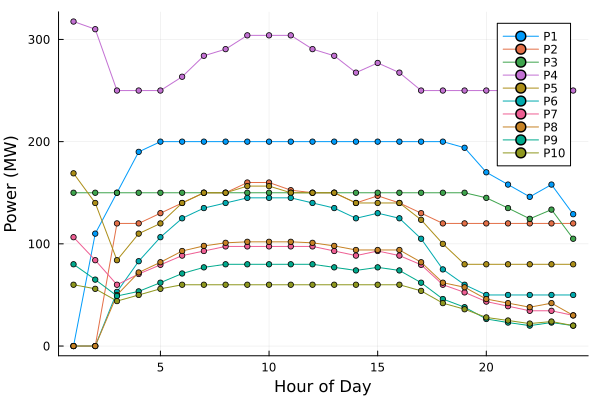

In [8]:
p2 = plot(range(1, 24, length=24), value.(model[:Ptot][1,:]), marker=(:circle,3), label="P1")
for row in 2:size(model[:Ptot])[1]
    p2 = plot!(range(1, 24, length=24), value.(model[:Ptot][row,:]), marker=(:circle,3), label=f"P{row}")
end
xaxis!("Hour of Day")
yaxis!("Power (MW)")
plot(p2, layout=(2,1))

# Cost-based UC with spinning reserve
In this problem, generators can offer part of their energy generation capacity as spinning reserve (SR). This means the generators can ramp up their production up to their spinning reserve allocation, in case of a sudden change in the grid energy balance such as an unexpected increase in energy demand, failure of some generators, or renewable under-performance. We need to add the following constraints to the problem [1]
$$
SR_{g,t} \le \bar{P}_{g,t} - Ptot_{g,t}
$$
$$
\sum_{g}^{} SR_{g,t} \ge \gamma L_{t}
$$
where $\gamma$ is the percentage of demand assigned as spinning reserve for resiliency, and $SR_{g,t}$ is the spinning reserve capacity for generator $g$ at time $t$. In this problem we assume $\gamma=0.4$. We also reduce the demand to 45% of its value in the previous section, to make the problem feasible [1].

In [9]:
model_options_SR = deepcopy(model_options_thermal)
model_options_SR.demands = model_options_SR.demands .* 0.45
model_options_SR.spinning_reserve=true

# model = build_model(model_options_SR);
# optimize!(model)

# println("Total operating cost is \$", objective_value(model))

true

# Cost-based UC with generator contingency
In this case, we consider scenarios when some of the generators go offline. For a UC solution to be able to handle unexpected generator outages, we can add generator contincencies to the problem. This means that in case of a sudden generator failure, the spinning reserve capacity from other generators should be able to cover the lost energy from the failed generator. The following constraints can be added to the problem for contingency considerations [1]:
$$
\sum_{g}^{} Ptot_{g,t} \ge L_{t}
$$
$$
SR_{g,t} \le \bar{P}_{g,t} - Ptot_{g,t}
$$
$$
\sum_{g \neq \acute{g}}^{} SR_{g,t} \ge  Ptot_{\acute{g},t}   \ \ \ \  \forall \acute{g} \in \Omega_{c}
$$
where $\Omega_{c}$ is the set of generators for which we consider contingency power. In this example let's assume $\Omega_{c}$ includes all generators except for g4.

In [10]:
model_options_cntgncy = deepcopy(model_options_SR)
model_options_cntgncy.spinning_reserve=false
model_options_cntgncy.contingency=true
model_options_cntgncy.omega_c=[1,2,3,5,6,7,8,9,10]

model = build_model(model_options_cntgncy);
optimize!(model)

println("Total operating cost is \$", objective_value(model))
println("Total startup cost is \$", sum(value.(model[:SUC])[:,:]))
println("Total fuel cost is \$", sum(value.(model[:FC])[:,:]))
println("Total shutdown cost is \$", sum(value.(model[:SDC])[:,:]))

Total operating cost is $210341.89154999994
Total startup cost is $199.0
Total fuel cost is $209759.39155
Total shutdown cost is $383.5


# Cost-based UC with demand response
So far we have only considered UC problems where demand is fixed and generation is optimized to meet the demand. In systems where the system operator can slightly change demand, the UC problem can be further optimized. This is called a demand response UC problem. In such cases, demand is no longer a fixed parameter, but a flexible parameter that needs to fall between a minimum and maximum acceptable values. Therefore, the following constraints need to be added to the problem [1]:
$$
\sum_{g}^{} Ptot_{g,t} \ge D_{t}
$$
$$
(1 - \varsigma_{min}) L_{t} \le D_{t} \le (1 + \varsigma_{max}) L_{t}
$$
$$
\sum_{t}^{} D_{t} = \sum_{t}^{} L_{t}
$$

In [11]:
model_options_DR = deepcopy(model_options_thermal)
model_options_DR.demands = model_options_DR.demands .* 0.45
model_options_DR.demand_response = true

model = build_model(model_options_DR);
optimize!(model)

println("Total operating cost is \$", objective_value(model))
println("Total startup cost is \$", sum(value.(model[:SUC])[:,:]))
println("Total fuel cost is \$", sum(value.(model[:FC])[:,:]))
println("Total shutdown cost is \$", sum(value.(model[:SDC])[:,:]))

Total operating cost is $209640.14329950005
Total startup cost is $142.0
Total fuel cost is $209228.64329950002
Total shutdown cost is $269.5


By changing the values of $\varsigma_{min}$ and $\varsigma_{max}$, we can explore the effect of these parameters on the UC problem.

In [12]:
DR_df = DataFrame([[],[]], ["cminmax", "DR"]);
for cminmax in [0,0.03,0.06,0.09,0.12,0.15,0.18]
    model_options_DR.cmin = cminmax
    model_options_DR.cmax = cminmax
    model = build_model(model_options_DR);
    optimize!(model)
    push!(DR_df, [cminmax, value.(model[:D][:])])
end

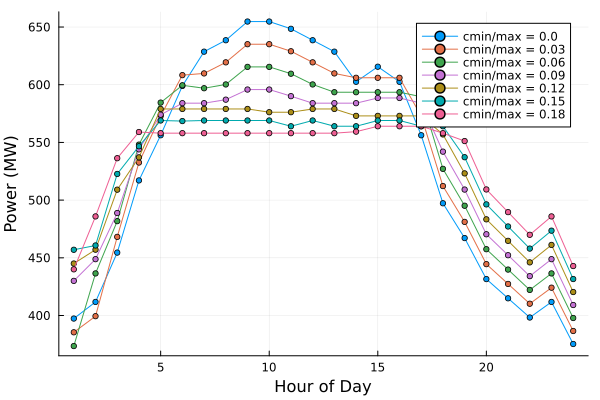

In [13]:
plt = plot(range(1, 24, length=24), DR_df[1,:DR], marker=(:circle,3), label=f"cmin/max = {DR_df[1,:cminmax]}")
for row in 2:size(DR_df)[1]
    plt = plot!(range(1, 24, length=24), DR_df[row,:DR], marker=(:circle,3), label=f"cmin/max = {DR_df[row,:cminmax]}")
end
xaxis!("Hour of Day")
yaxis!("Power (MW)")
plot(plt, layout=(2,1))

# Price-based UC
In price-based unit commitment, the goal is to maximize revenue. In this case, we take into account the price of energy as well as the cost of generation which enatils fuel cost, startup cost, and shutdown cost. The price based Uc formulation is very similar to cost-based UC, with 2 distinctions [1]:<br>
**Objective Function:**
$$
\underset{p,u,y,z} {max} \ \ \ \ \sum_{g,t}^{} \left\{ \lambda_{t} Ptot_{g,t} - \left[ FC_{g,t} + Su_{g} y_{g,t} + Sd_{g} z_{g,t} \right] \right\}
$$
**Generation-demand constraint:**
$$
\sum_{g}^{} Ptot_{g,t} \le L_{t}
$$

In [14]:
lambdas = [14.72, 15.62, 15.62, 15.62, 15, 16, 20, 23.5, 24, 21, 20, 17, 18, 17.5, 18.8, 17.5, 23.5, 18.8, 18.9, 18.9, 20.9, 20.9, 20.5, 15.62];

In [15]:
model_options_PB = deepcopy(model_options_thermal)
model_options_PB.price_based = true
model_options_PB.lambdas = lambdas

model = build_model(model_options_PB);
optimize!(model)

println("Total revenue is \$", objective_value(model))
println("Total startup cost is \$", sum(value.(model[:SUC])[:,:]))
println("Total fuel cost is \$", sum(value.(model[:FC])[:,:]))
println("Total shutdown cost is \$", sum(value.(model[:SDC])[:,:]))

Total revenue is $60643.77202499994
Total startup cost is $440.5
Total fuel cost is $378434.2679750001
Total shutdown cost is $163.5


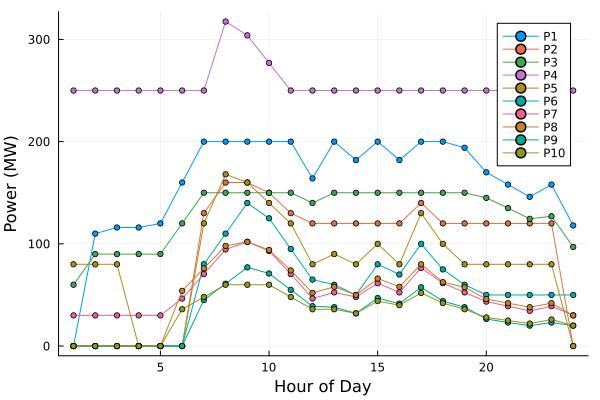

In [16]:
plt = plot(range(1, 24, length=24), value.(model[:Ptot][1,:]), marker=(:circle,3), label="P1")
for row in 2:size(model[:Ptot])[1]
    plt = plot!(range(1, 24, length=24), value.(model[:Ptot][row,:]), marker=(:circle,3), label=f"P{row}")
end
xaxis!("Hour of Day")
yaxis!("Power (MW)")
plot(plt, layout=(2,1))

# References
1. Soroudi, Alireza. Power system optimization modeling in GAMS. Vol. 78. Berlin/Heidelberg, Germany: Springer, 2017.
2. Ademovic A, Bisanovic S, Hajro M. A genetic algorithm solution to the unit commitment problem based on real-coded chromosomes and fuzzy optimization. InMelecon 2010-2010 15th IEEE Mediterranean Electrotechnical Conference 2010 Apr 26 (pp. 1476-1481). IEEE.
3. Arroyo JM, Conejo AJ. Optimal response of a thermal unit to an electricity spot market. IEEE Transactions on power systems. 2000 Aug;15(3):1098-104.